In [3]:
import tensorflow as tf
from tensorflow import keras

DATA_DIR = 'gtsrb_yolo'
IMG_SIZE = 224  # EfficientNetB0/ResNet usam 224x224 por padrão
BATCH = 32

train_ds = keras.utils.image_dataset_from_directory(
    f'{DATA_DIR}/train', image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH, label_mode='categorical', shuffle=True, seed=42, color_mode='rgb')

val_ds = keras.utils.image_dataset_from_directory(
    f'{DATA_DIR}/val', image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH, label_mode='categorical', shuffle=False, color_mode='rgb')

test_ds = keras.utils.image_dataset_from_directory(
    f'{DATA_DIR}/test', image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH, label_mode='categorical', shuffle=False, color_mode='rgb')

num_classes = len(train_ds.class_names)

# performance: cache e prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 21312 files belonging to 43 classes.
Found 2664 files belonging to 43 classes.
Found 2664 files belonging to 43 classes.


In [8]:
from tensorflow.keras.applications import EfficientNetV2B0

base = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
from tensorflow.keras import layers, optimizers, callbacks
from keras.src.applications.efficientnet_v2 import preprocess_input


base.trainable = False  # congela o backbone

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='gtsrb_efficientnetb0')

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, restore_best_weights=True
    )
]

history_frozen = model.fit(
    train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks, verbose=1
)

Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 212s 310ms/step - accuracy: 0.6219 - loss: 1.3883 - val_accuracy: 0.7969 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 191s 287ms/step - accuracy: 0.8107 - loss: 0.6971 - val_accuracy: 0.8746 - val_loss: 0.5242 - learning_rate: 0.0010
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 196s 294ms/step - accuracy: 0.8562 - loss: 0.5276 - val_accuracy: 0.8975 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 197s 296ms/step - accuracy: 0.8781 - loss: 0.4422 - val_accuracy: 0.9155 - val_loss: 0.3502 - learning_rate: 0.0010
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 200s 300ms/step - accuracy: 0.8910 - loss: 0.3866 - val_accuracy: 0.9215 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 202s 303ms/step - accuracy: 0.9024 - loss: 0.3479 - val_accuracy: 0.9298 - val_loss: 0.2776 - learning_rate: 0.0010
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 204s 306ms/step - accura

In [12]:
# destrava parcialmente (por ex., últimas 30 camadas)
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # LR menor no FT
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks, verbose=1
)

Epoch 1/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 247s 359ms/step - accuracy: 0.9211 - loss: 0.2685 - val_accuracy: 0.9625 - val_loss: 0.1342 - learning_rate: 1.0000e-04
Epoch 2/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 240s 360ms/step - accuracy: 0.9539 - loss: 0.1582 - val_accuracy: 0.9707 - val_loss: 0.0993 - learning_rate: 1.0000e-04
Epoch 3/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 245s 368ms/step - accuracy: 0.9672 - loss: 0.1158 - val_accuracy: 0.9782 - val_loss: 0.0787 - learning_rate: 1.0000e-04
Epoch 4/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 247s 370ms/step - accuracy: 0.9753 - loss: 0.0873 - val_accuracy: 0.9812 - val_loss: 0.0652 - learning_rate: 1.0000e-04
Epoch 5/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 252s 378ms/step - accuracy: 0.9811 - loss: 0.0695 - val_accuracy: 0.9824 - val_loss: 0.0589 - learning_rate: 1.0000e-04
Epoch 6/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 251s 377ms/step - accuracy: 0.9855 - loss: 0.0587 - val_accuracy: 0.9835 - val_loss: 0.0574 - learning_rate: 1.0000e-04
Epoch 7/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'test_acc: {test_acc:.4f}')

# model.save('gtsrb_efficientnetb0_imagenet_finetuned.h5')  # ou .keras

84/84 - 21s - 251ms/step - accuracy: 0.9925 - loss: 0.0264
test_acc: 0.9925


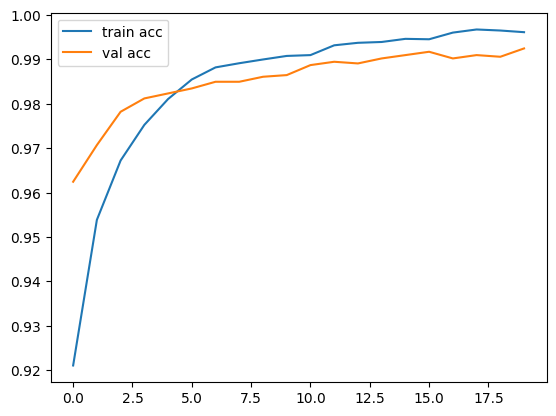

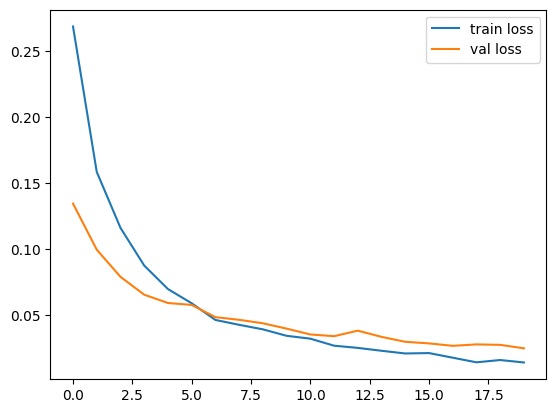

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_ft.history['accuracy'], label='train acc')
plt.plot(history_ft.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history_ft.history['loss'], label='train loss')
plt.plot(history_ft.history['val_loss'], label='val loss')
plt.legend()
plt.show()